In [1]:
import numpy as np
import utm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import linecache
import my_functions as mf
from scipy.ndimage import gaussian_filter

In [2]:
%matplotlib inline

In [3]:
file = '/home/flora/Documents/FLORA/interpolation_misc/inv_datasynt05_NLCG_063.rho'

### Open model1 - modem 

In [4]:
ld=linecache.getline(file, 2)
lx=linecache.getline(file, 3)
ly=linecache.getline(file, 4)
lz=linecache.getline(file, 5)
dim=ld.split()
nx=int(dim[0])
ny=int(dim[1])
nz=int(dim[2])
#vecteur de taille de maille
hx=np.hstack(float(lx.split()[i]) for i in np.arange(nx) )
hy=np.hstack(float(ly.split()[i]) for i in np.arange(ny) )
hz=np.hstack(float(lz.split()[i]) for i in np.arange(nz) )

#model values
ind=7
rho = np.zeros((nx,ny,nz))

for k in range(nz):
    for j in range(ny):
        l=linecache.getline(file, ind)
        rho[:,j,k]=np.hstack(float(l.split()[i]) for i in np.arange(nx) )[::-1]
        ind = ind+1        
    ind = ind+1

rho = (np.e**rho) 

use coordinates

#### Transform coordinates - lat lon to utm 

In [5]:
refE,refN,zone,l = utm.from_latlon(-23.965, -69.475)

#Position centre des mailes (utm & lat/lon)
ctx=np.ones(len(hx))
for i in np.arange(len(hx)):
    ctx[i]=(sum(hx[0:i])+sum(hx[0:i+1]))/2+refN
    
cty=np.ones(len(hy))
for i in np.arange(len(hy)):
    cty[i]=(sum(hy[0:i])+sum(hy[0:i+1]))/2+refE

ctz=np.ones(len(hz))
for i in np.arange(len(hz)):
    ctz[i]=(sum(hz[0:i])+sum(hz[0:i+1]))/2

#ctz = ctz*(-1)

Xla=np.zeros(len(ctx))
Ylon=np.zeros(len(cty))

# for j in range(len(cty)):
#     for i in range(len(ctx)):
#         U=utm.to_latlon(cty[j],ctx[i],zone,l)
#         Xla[i]=U[0]
#         Ylon[j]=U[1]


### Select area from model

In [6]:
# #north
# xmin = 7515000.
# xmax = 7524000.
# #east
# ymin = 618000.
# ymax = 634000.

# zmin = 0.
# zmax = 3000.

#north
xmin = 7517000.
xmax = 7521000.
#east
ymin = 626000.
ymax = 632000.

zmin = 0.
zmax = 3000.

In [7]:
xgrid,ygrid,zgrid,xa,ya,za,rho_n = mf.select_area(xmin,xmax,ymin,ymax,zmin,zmax,ctx,cty,ctz,rho)

In [8]:
print(rho_n.shape)

(10, 15, 43)


In [9]:
print(rho.shape)

(54, 69, 80)


In [25]:
rho1 = np.ravel(rho_n)
lx,ly,lz = rho_n.shape
ln = rho1.size

In [11]:
# import MT stations coordinates
path = '/home/flora/Documents/FLORA/interpolation_misc/coord'
data = np.loadtxt(path,dtype='float',usecols=(0,1,2))

stn = data[:,0]
lat = data[:,1]
lon = data[:,2]

Xla=np.zeros(len(lat))
Ylon=np.zeros(len(lon))
for j in range(len(lat)):
    for i in range(len(lon)):
        U=utm.from_latlon(lat[j],lon[i],zone)
        Xla[i]=U[0]
        Ylon[j]=U[1]



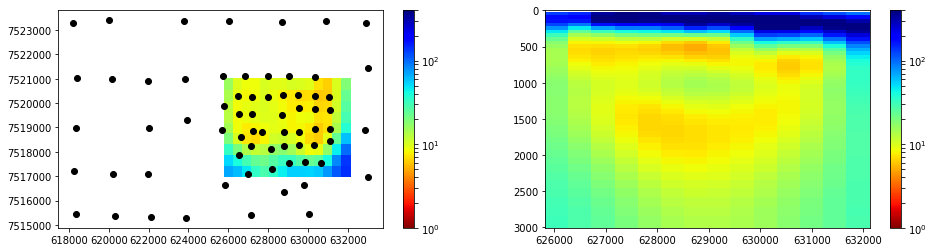

In [12]:
cmap = plt.cm.jet
cmap_r = mf.reverse_colourmap(cmap)

east,north = np.meshgrid(ya,xa)
depth,east1 = np.meshgrid(za,ya)

z_plot = np.argmin(np.abs(za-750))
x_plot = np.argmin(np.abs(xa-7519000))

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.pcolor(east,north,rho_n[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.plot(Xla,Ylon,'ko')
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(east1,depth,rho_n[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()
plt.show()

### Define control points for interpolation 

In [300]:
# Control points -  control points > interpolation points

xcn = 45
ycn = 45
zcn = 40

c1 = np.linspace(xmin,xmax,xcn)
c2 = np.linspace(ymin,ymax,ycn)

ca = np.linspace(zmin,2000,zcn)
cb = np.linspace(2000,zmax,10)

c3 = np.hstack((ca,cb))

X,Y,Z = np.meshgrid(c1,c2,c3,indexing='ij')


xc = np.ravel(X)
yc = np.ravel(Y)
zc = np.ravel(Z)

In [301]:
print(xc.size,yc.size,zc.size)

101250 101250 101250


### Calculate interpolation matrix A

In [316]:
# Calculate interpolation function

t = 0.95
A = mf.calc_A_by_column(xgrid,ygrid,zgrid,xc,yc,zc,1,t)

In [317]:
AAT = np.dot(A,A.T)

In [318]:
h0 = np.trace(AAT)/ln

In [319]:
mu = 1E-13*h0
print(mu)

1.0123043909737678e-08


In [320]:
w = np.linalg.solve(AAT+(mu*np.identity(ln)),rho1)

In [321]:
p = np.dot(A.T,w)

Check if A recovers data

In [322]:
rho0 = np.dot(A,p)
rho0_m = rho0.reshape((lx,ly,lz))

In [323]:
np.linalg.norm(rho_n-rho0_m)

218.56372109101443

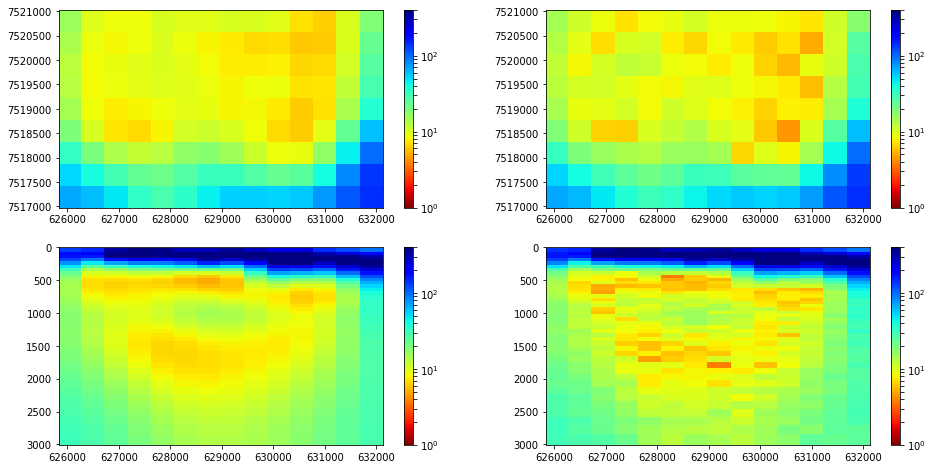

In [324]:
cmap = plt.cm.jet
cmap_r = mf.reverse_colourmap(cmap)

east,north = np.meshgrid(ya,xa)
depth,east1 = np.meshgrid(za,ya)

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.pcolor(east,north,rho_n[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(east,north,rho0_m[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(east1,depth,rho_n[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(east1,depth,rho0_m[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.show()

### Interpolation points 

In [325]:
# #Interpolation points

dx0 = (xa[1:]+xa[:-1])/2
dy0 = (ya[1:]+ya[:-1])/2
dz0 = (za[1:]+za[:-1])/2

# dx1 = np.copy(x1)
# dy1 = np.copy(y1)
# dz1 = np.copy(z1)

x0n = len(dx0)
y0n = len(dy0)
z0n = len(dz0)

X0,Y0,Z0 = np.meshgrid(dx0,dy0,dz0,indexing='ij')

x0 = np.ravel(X0)
y0 = np.ravel(Y0)
z0 = np.ravel(Z0)


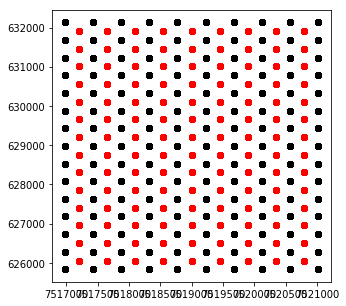

In [326]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'ro')
plt.plot(xgrid,ygrid,'ko')

### Calculate matrix A at interpolation points

In [327]:
A0 = mf.calc_A_by_column(x0,y0,z0,xc,yc,zc,1,t)

In [328]:
# Interpolated data

rho0 = np.dot(A0,p)
rho0_m = rho0.reshape(x0n,y0n,z0n)

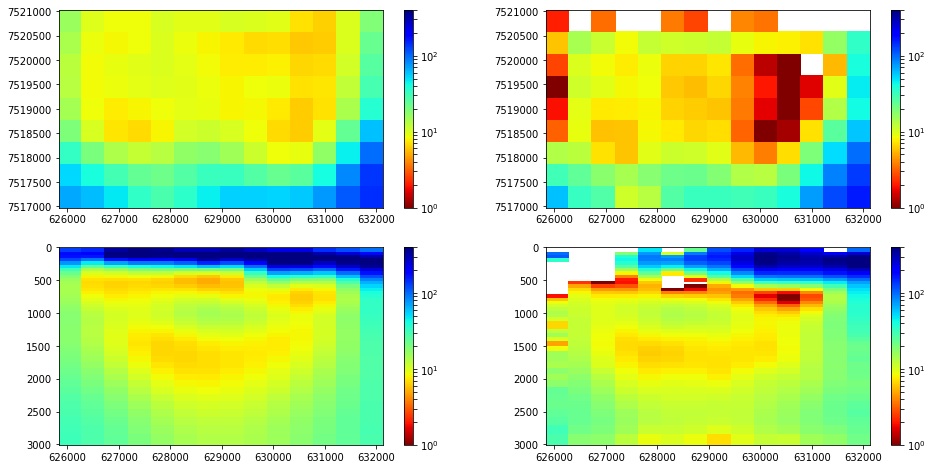

In [329]:
east,north = np.meshgrid(ya,xa)
depth,east1 = np.meshgrid(za,ya)

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.pcolor(east,north,rho_n[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(east,north,rho0_m[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(east1,depth,rho_n[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(east1,depth,rho0_m[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.show()